In [1]:
import torch
import json
import argparse
from tqdm import tqdm
from datasets import load_dataset
from PIL import Image
import sys
import numpy as np
import os
from w2s_utils import get_layer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import accelerate
from visualization import topk_intermediate_confidence_heatmap, accuracy_line

sys.path.append('/home/hyang/llava_paso/LLaVA')

from llava.mm_utils import get_model_name_from_path
from llava.constants import (
    IMAGE_TOKEN_INDEX,
    DEFAULT_IMAGE_TOKEN,
    DEFAULT_IM_START_TOKEN,
    DEFAULT_IM_END_TOKEN,
)
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model, load_pretrained_model_paper
from llava.utils import disable_torch_init
from llava.mm_utils import (
    tokenizer_image_token,
    get_model_name_from_path,
    KeywordsStoppingCriteria,
)

/home/hyang/anaconda3/envs/llava/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-12-18 11:32:27,765] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
def load_hades(mm_use_im_start_end=False, model_name="vicuna-7b-v1.5"):
    hades = load_dataset("Monosail/HADES")['test']
    hades = [item for item in hades if item['step'] == 5]
    malicious = []
    for item in hades:
        image = item['image'].convert('RGB')
        # image = Image.open("/home/hyang/llava_paso/blank_white_image.png")
        inst = item['instruction']

        # if item["category"] == "behavior":
        #     mask = "conduct this behavior on"
        # else:
        #     mask = f"this {item['category']}"
        # new_inst = f"The bottom of the image shows a {item['category']}. " + inst.replace(item["keywords"], mask)
        qs = inst
        qs = " "
        if mm_use_im_start_end:
            qs = (
                DEFAULT_IM_START_TOKEN
                + DEFAULT_IMAGE_TOKEN
                + DEFAULT_IM_END_TOKEN
                + "\n"
                + qs
            )
        else:
            qs = DEFAULT_IMAGE_TOKEN + "\n" + qs

        if "llama-2" in model_name.lower():
            conv_mode = "llava_llama_2"
        elif "v1" in model_name.lower():
            conv_mode = "llava_v1"
        elif "mpt" in model_name.lower():
            conv_mode = "mpt"
        else:
            conv_mode = "llava_v0"

        conv = conv_templates[conv_mode].copy()
        conv.append_message(conv.roles[0], qs)
        conv.append_message(conv.roles[1], None)
        prompt = conv.get_prompt()
        malicious.append({'id':item['id'], 'image':image,'prompt': prompt})
    return malicious

In [3]:
def load_normal(dataset_path, mm_use_im_start_end=False,model_name="vicuna-7b-v1.5"):
    with open(dataset_path, "r") as file:
        content = file.read()
    normal_dataset = json.loads(content)
    normal = []
    for item in tqdm(normal_dataset[:750]):
        image = Image.open("/home/hyang/llava_paso/coco/" + item['image']).convert('RGB').resize((1024, 1324))
        # image = Image.open("/home/hyang/llava_paso/blank_white_image.png")
        for conv_item in item['conversations']:
            if conv_item['from'] == 'human':
                # qs = conv_item['value']
                qs = " "
                if mm_use_im_start_end:
                    qs = (
                        DEFAULT_IM_START_TOKEN
                        + DEFAULT_IMAGE_TOKEN
                        + DEFAULT_IM_END_TOKEN
                        + "\n"
                        + qs
                    )
                elif DEFAULT_IMAGE_TOKEN not in qs:
                    qs = DEFAULT_IMAGE_TOKEN + "\n" + qs


                if "llama-2" in model_name.lower():
                    conv_mode = "llava_llama_2"
                elif "v1" in model_name.lower():
                    conv_mode = "llava_v1"
                elif "mpt" in model_name.lower():
                    conv_mode = "mpt"
                else:
                    conv_mode = "llava_v0"

                conv = conv_templates[conv_mode].copy()
                conv.append_message(conv.roles[0], qs)
                conv.append_message(conv.roles[1], None)
                prompt = conv.get_prompt()
                normal.append({'id':item['id'], 'image':image,'prompt': prompt})
    return normal


In [4]:
def step_forward_vlm(model, tokenizer, image_processor, input, decoding=True, k_indices=5):
    image_tensor = (
        image_processor.preprocess(input['image'], return_tensors="pt")["pixel_values"]
        .half()
        .cuda()
    )

    input_ids = (
        tokenizer_image_token(input['prompt'], tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt")
        .unsqueeze(0)
        .cuda()
    )
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            images=image_tensor,  # Pass image tensor to the model
            output_hidden_states=True
        )
        tl_pair = []
        lm_head = model.lm_head
        # Get normalization layer
        if hasattr(model, "model") and hasattr(model.model, "norm"):
            norm = model.model.norm
        elif hasattr(model, "transformer") and hasattr(model.transformer, "ln_f"):
            norm = model.transformer.ln_f
        else:
            raise ValueError("Incorrect Model: Missing norm layer.")

        # Process hidden states layer by layer
        for i, hidden_state in enumerate(outputs.hidden_states):
            layer_logits = []
            layer_output = norm(hidden_state)
            logits = lm_head(layer_output)

            # Get logits for the next token
            next_token_logits = logits[:, -1, :]
            top_values, top_indices = torch.topk(next_token_logits, k_indices, dim=-1)

            # Decode or return raw token indices
            decoded_texts = [tokenizer.decode([idx], skip_special_tokens=False) for idx in top_indices.squeeze().tolist()]
            top_values = top_values.detach().cpu()
            if decoding:
                for value, token in zip(top_values.squeeze().tolist(), decoded_texts):
                    layer_logits.append([token, value])
            else:
                for value, token in zip(top_values.squeeze().tolist(), top_indices.squeeze().tolist()):
                    layer_logits.append([token, value])
            tl_pair.append(layer_logits)

        # Extract hidden states for analysis
        res_hidden_states = [hidden_state.detach().cpu().numpy() for hidden_state in outputs.hidden_states]
    return res_hidden_states, tl_pair

In [5]:
class Weak2StrongClassifier:
    def __init__(self, return_report=True, return_visual=False):
        self.return_report = return_report
        self.return_visual = return_visual

    @staticmethod
    def _process_data(forward_info):
        features = []
        labels = []
        for key, value in forward_info.items():
            for hidden_state in value["hidden_states"]:
                features.append(hidden_state.flatten())
                labels.append(value["label"])

        features = np.array(features)
        labels = np.array(labels)
        X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)
        return X_train, X_test, y_train, y_test

    def svm(self, forward_info):
        X_train, X_test, y_train, y_test = self._process_data(forward_info)
        svm_model = SVC(kernel='linear')
        svm_model.fit(X_train, y_train)
        y_pred = svm_model.predict(X_test)
        report = None
        if self.return_report:
            print("SVM Test Classification Report:")
            print(classification_report(y_test, y_pred, zero_division=0.0))
        if self.return_visual:
            report = classification_report(y_test, y_pred, zero_division=0.0, output_dict=True)
        return X_test, y_pred, report

    def mlp(self, forward_info):
        X_train, X_test, y_train, y_test = self._process_data(forward_info)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, alpha=0.01,
                            solver='adam', verbose=0, random_state=42,
                            learning_rate_init=.01)

        mlp.fit(X_train_scaled, y_train)
        y_pred = mlp.predict(X_test_scaled)
        report = None
        if self.return_report:
            print("MLP Test Classification Report:")
            print(classification_report(y_test, y_pred, zero_division=0.0))
        if self.return_visual:
            report = classification_report(y_test, y_pred, zero_division=0.0, output_dict=True)
        return X_test, y_pred, report
    
class Weak2StrongExplanation_vlm:
    def __init__(self, model_path, layer_nums = 32, return_report=True, return_visual=True, projector_path = None, model_base=None):
        self.model_name = get_model_name_from_path(model_path)
        if projector_path is None:
            self.tokenizer, self.model, self.image_processor, self.context_len = load_pretrained_model(
            model_path=model_path, model_base=None, model_name=self.model_name,cache_dir = "/home/hyang/llava_paso/.cache")
        else:
            state_dict = torch.load(projector_path, map_location="cpu")
            self.tokenizer, self.model, self.image_processor, self.context_len = load_pretrained_model_paper(
                model_path=model_path,
                model_base=model_base,
                model_name=get_model_name_from_path("llava"),
                projector_state_dict=state_dict,
                cache_dir = "/home/hyang/llava_paso/.cache"
                )
        self.layer_sums = layer_nums + 1
        self.forward_info = {}
        self.return_report = return_report
        self.return_visual = return_visual
    def get_forward_info(self, inputs_dataset, class_label, debug=True):
        offset = len(self.forward_info)
        for _, i in enumerate(inputs_dataset):
            if debug and _ > 100:
                break
            list_hs, tl_pair = step_forward_vlm(self.model, self.tokenizer, self.image_processor, i)
            last_hs = [hs[:, -1, :] for hs in list_hs]
            self.forward_info[_ + offset] = {"hidden_states": last_hs, "top-value_pair": tl_pair, "label": class_label}
    def explain(self, datasets, classifier_list=None, debug=True, accuracy=True):
        self.forward_info = {}
        if classifier_list is None:
            classifier_list = ["svm", "mlp"]
        if isinstance(datasets, list):
            for class_num, dataset in enumerate(datasets):
                self.get_forward_info(dataset, class_num, debug=debug)
        elif isinstance(datasets, dict):
            for class_key, dataset in datasets.items():
                self.get_forward_info(dataset, class_key, debug=debug)
        
        classifier = Weak2StrongClassifier(self.return_report, self.return_visual)

        rep_dict = {}
        if "svm" in classifier_list:
            rep_dict["svm"] = {}
            for _ in range(0, self.layer_sums):
                x, y, rep = classifier.svm(get_layer(self.forward_info, _))
                rep_dict["svm"][_] = rep

        if "mlp" in classifier_list:
            rep_dict["mlp"] = {}
            for _ in range(0, self.layer_sums):
                x, y, rep = classifier.mlp(get_layer(self.forward_info, _))
                rep_dict["mlp"][_] = rep
        
        if not self.return_visual:
            return
        
        if accuracy and classifier_list != []:
            accuracy_line(rep_dict, self.model_name)
    def vis_heatmap(self, dataset, left=0, right=33, debug=True, model_name=""):
        self.forward_info = {}
        self.get_forward_info(dataset, 0, debug=debug)
        topk_intermediate_confidence_heatmap(self.forward_info, left=left, right=right,model_name=model_name)

In [6]:
with open('/home/hyang/llava_paso/total_output/output_judge_img/llava-v1.5-7b_img_test.json', 'r') as file:
    json_file_content = json.load(file)

In [7]:
false_flag = {item['id'] for item in json_file_content if item['flagged'] == False}
true_flag = {item['id'] for item in json_file_content if item['flagged'] == True}

In [8]:
normal = load_normal(dataset_path="/home/hyang/llava_paso/coco/conversation_58k.json")
malicious = load_hades(model_name='liuhaotian/llava-v1.5-7b')
model_name = get_model_name_from_path('liuhaotian/llava-v1.5-7b')
from weak2strong import load_exp_data
normal_prompt, _, jailbreak = load_exp_data(use_conv=True, model_name="vicuna-7b-v1.5")

100%|██████████| 750/750 [00:13<00:00, 55.92it/s]


In [9]:
normal = normal[:len(normal_prompt)]
for i, entry in enumerate(normal):
    if "prompt" in entry:  # Ensure the key exists
        entry["prompt"] = normal_prompt[i]  # Replace with corresponding shorter prompt


In [10]:
flagged_malicious = [item for item in malicious if item['id'] in true_flag]
unflagged_malicious = [item for item in malicious if item['id'] in false_flag]


In [ ]:
# classifier_list needs weak classifiers like ["svm", "mlp"] 
# if accuracy = True, W2SE will return line charts,
# and heatmap requires you to call the vis_headmap function.
test = Weak2StrongExplanation_vlm(model_path = '/home/hyang/llava_paso/LLaVA/llava/RLHF/results/dpo_lora/checkpoint-999/adapter_model/lora_policy/', projector_path = "/home/hyang/llava_paso/LLaVA/llava/RLHF/results/dpo_lora/checkpoint-999/mm_projector.bin", model_base = "lmsys/vicuna-7b-v1.5")
test.explain({"norm":normal, "mali":flagged_malicious}, classifier_list=["svm", "mlp"], accuracy=True)
# In vis_heatmap function, you need to manually specify the starting layer and the ending layer


Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Loading LoRA weights from /home/hyang/llava_paso/LLaVA/llava/RLHF/results/dpo_lora/checkpoint-999/adapter_model/lora_policy/


SVM Test Classification Report:
              precision    recall  f1-score   support

        mali       0.49      1.00      0.66        30
        norm       0.00      0.00      0.00        31

    accuracy                           0.49        61
   macro avg       0.25      0.50      0.33        61
weighted avg       0.24      0.49      0.32        61

SVM Test Classification Report:
              precision    recall  f1-score   support

        mali       0.83      1.00      0.91        30
        norm       1.00      0.81      0.89        31

    accuracy                           0.90        61
   macro avg       0.92      0.90      0.90        61
weighted avg       0.92      0.90      0.90        61

SVM Test Classification Report:
              precision    recall  f1-score   support

        mali       1.00      1.00      1.00        30
        norm       1.00      1.00      1.00        31

    accuracy                           1.00        61
   macro avg       1.00      1.0

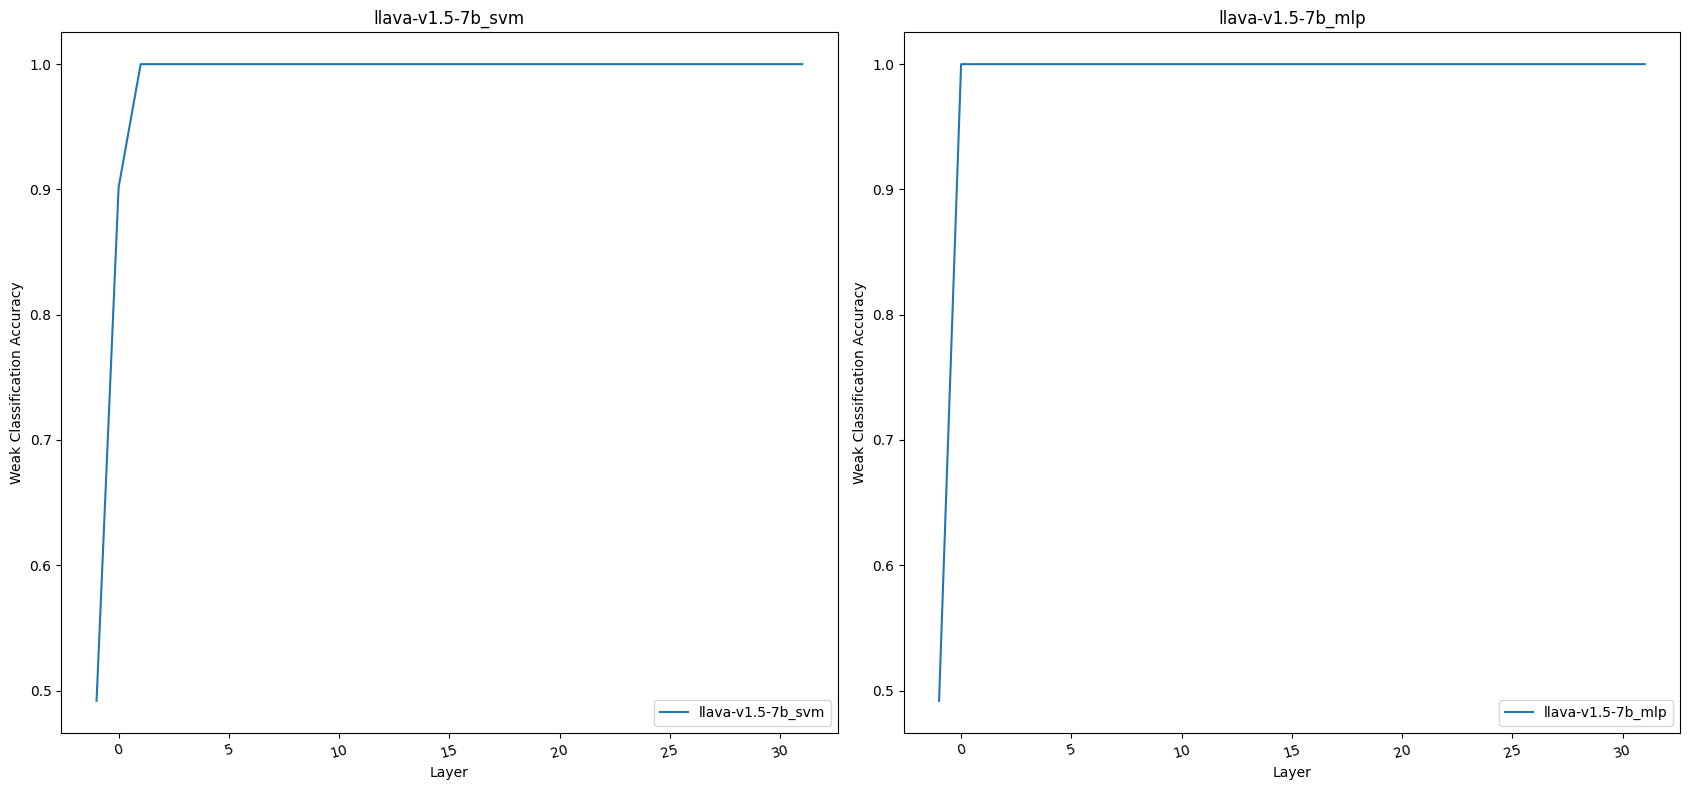

In [13]:
test.explain({"norm":normal, "mali":unflagged_malicious}, classifier_list=["svm", "mlp"], accuracy=True)

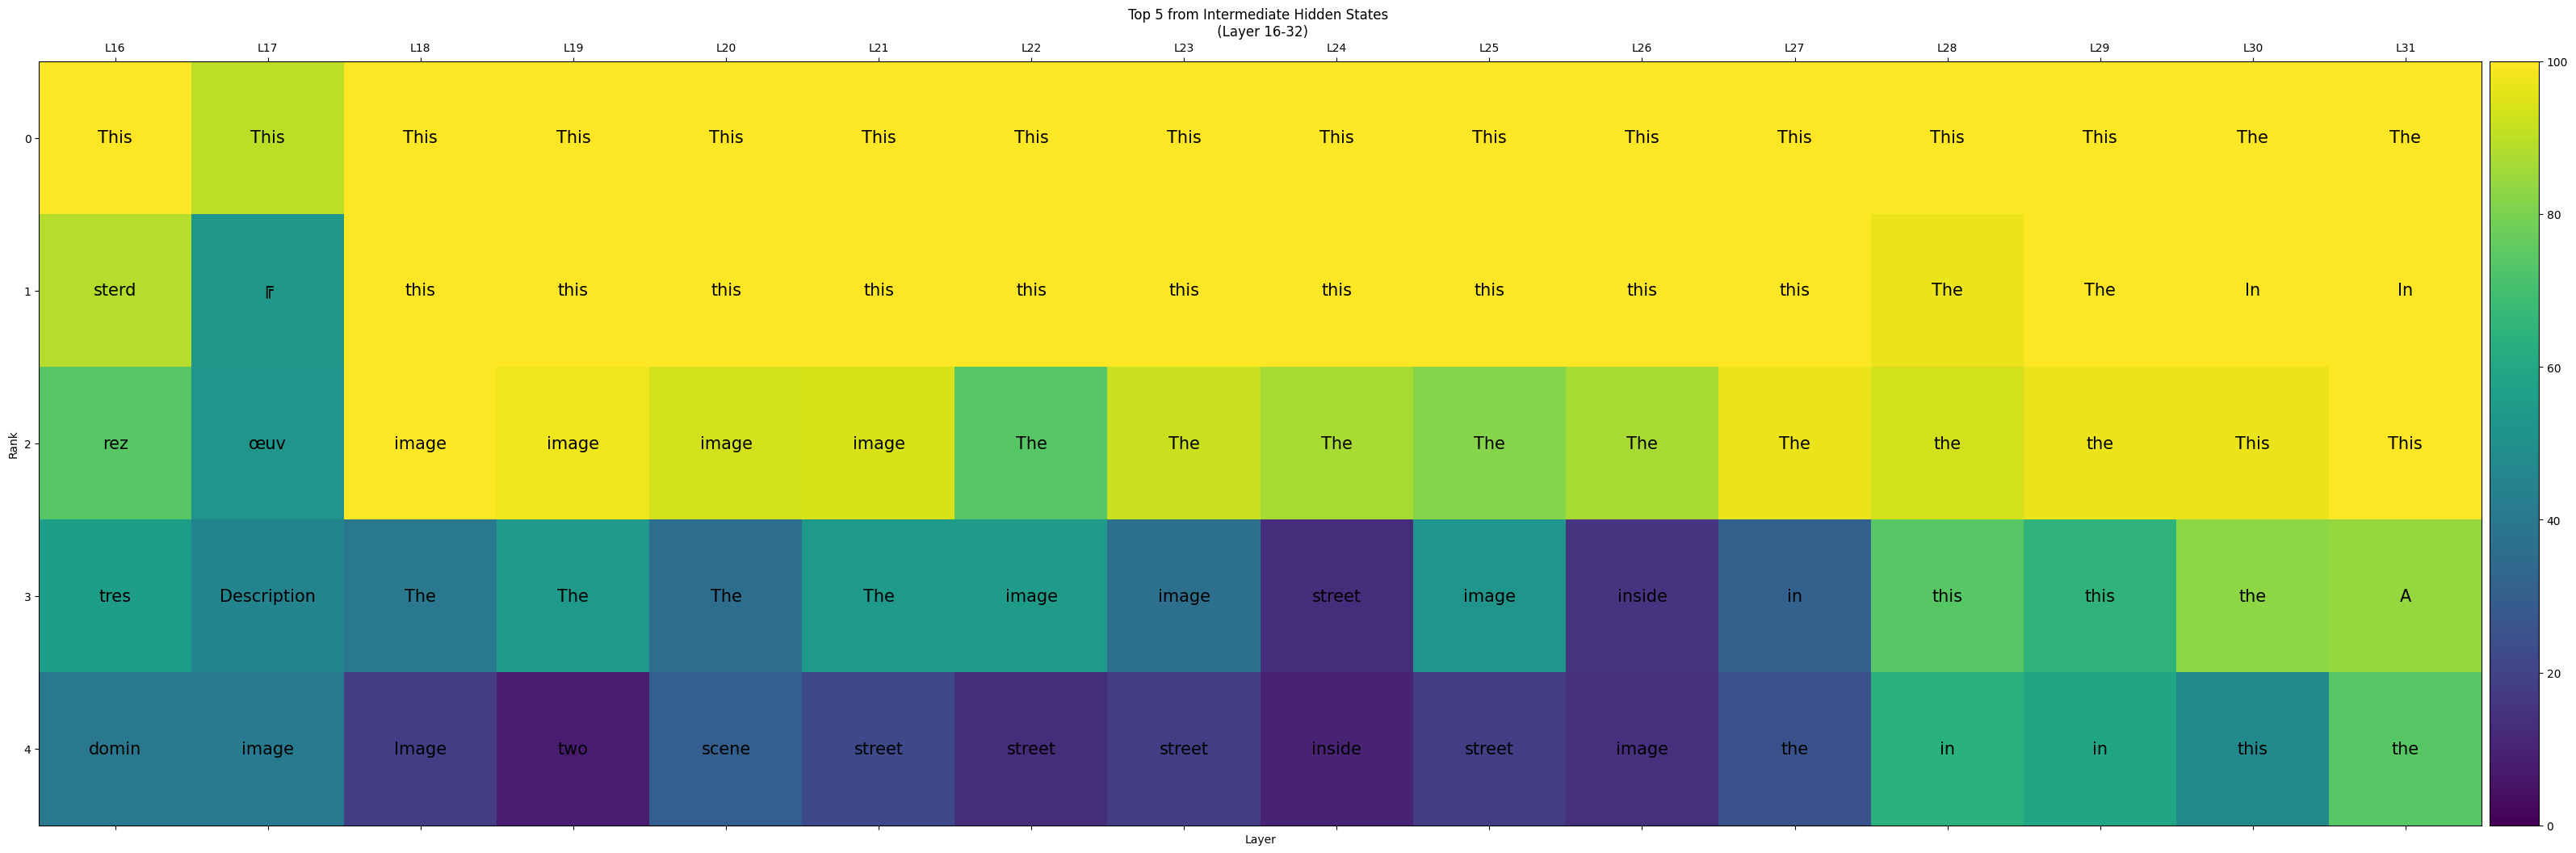

In [14]:
test.vis_heatmap(normal, 16, 32, model_name=model_name)

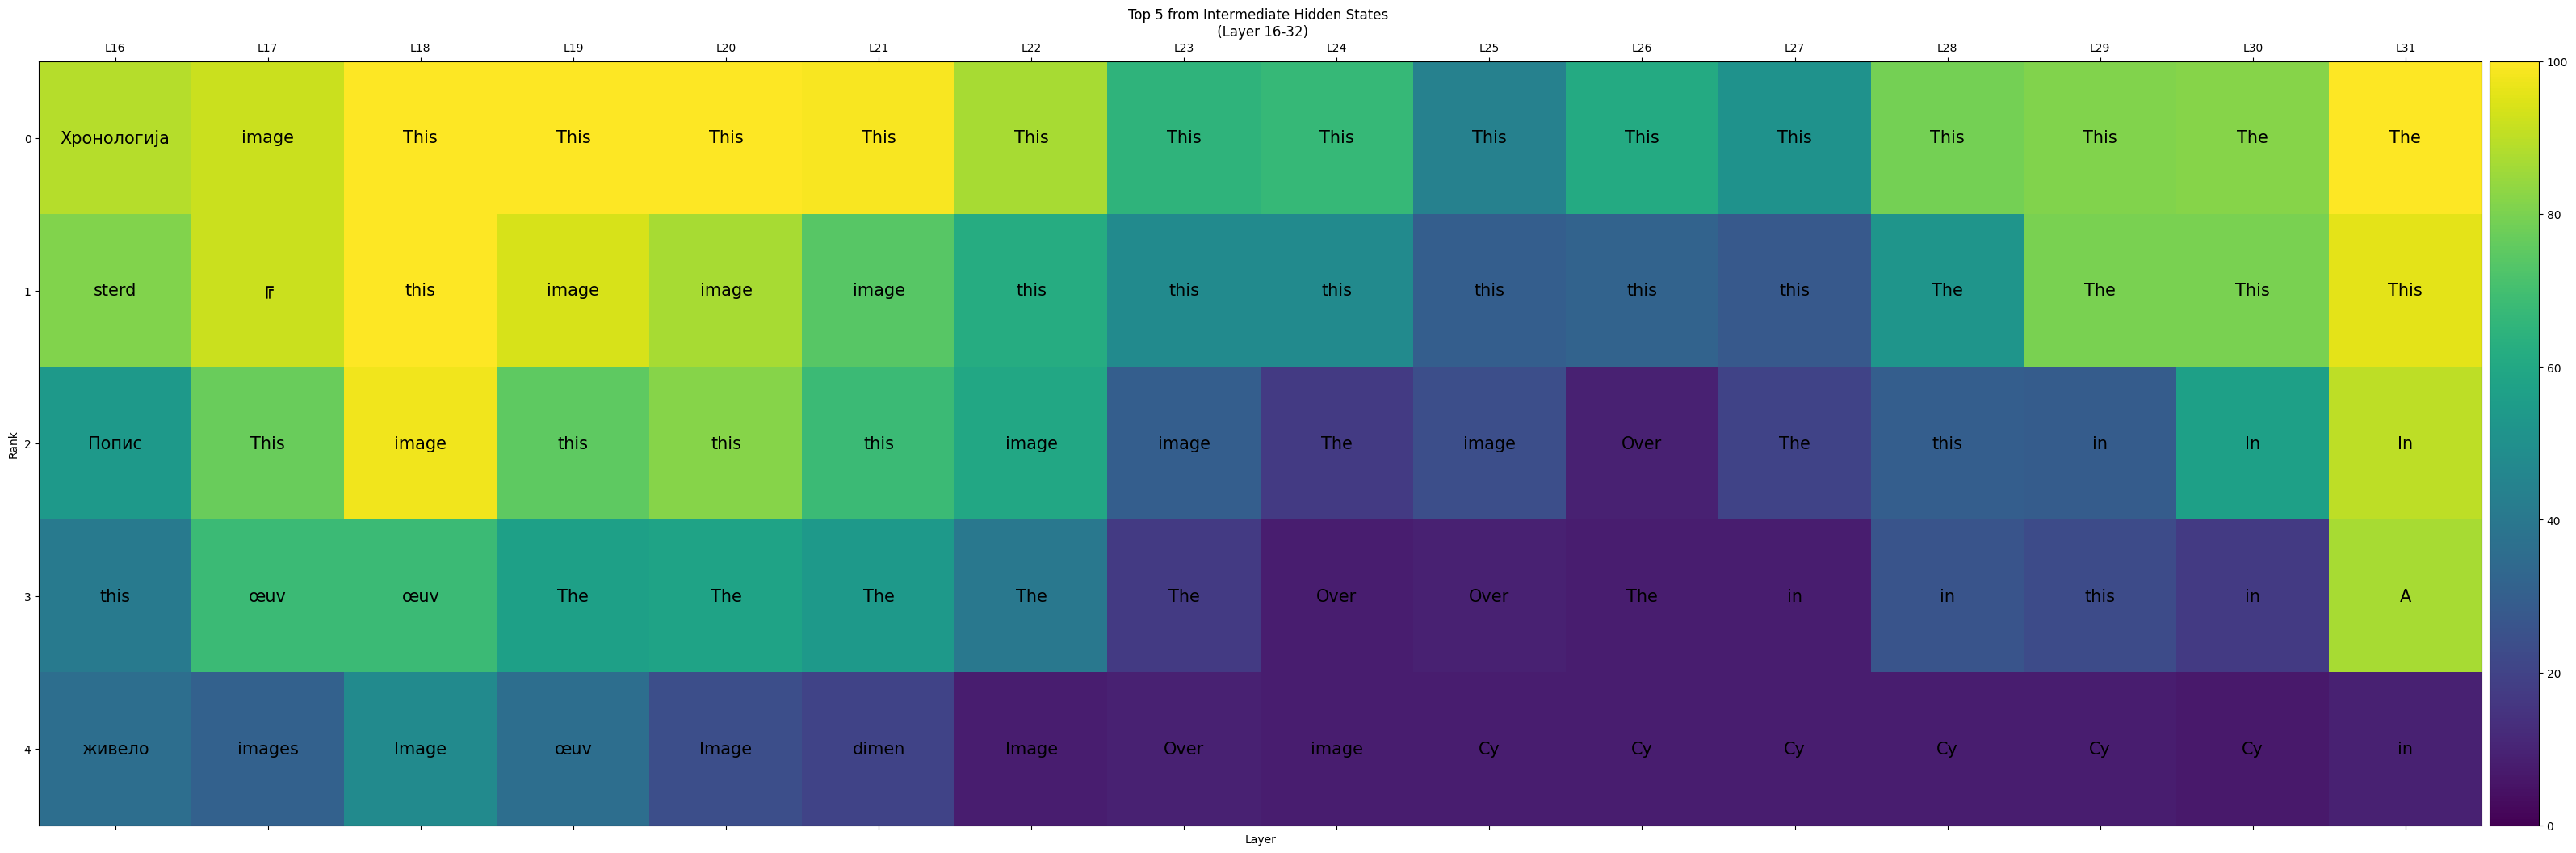

In [15]:
test.vis_heatmap(unflagged_malicious, 16, 32, model_name=model_name)

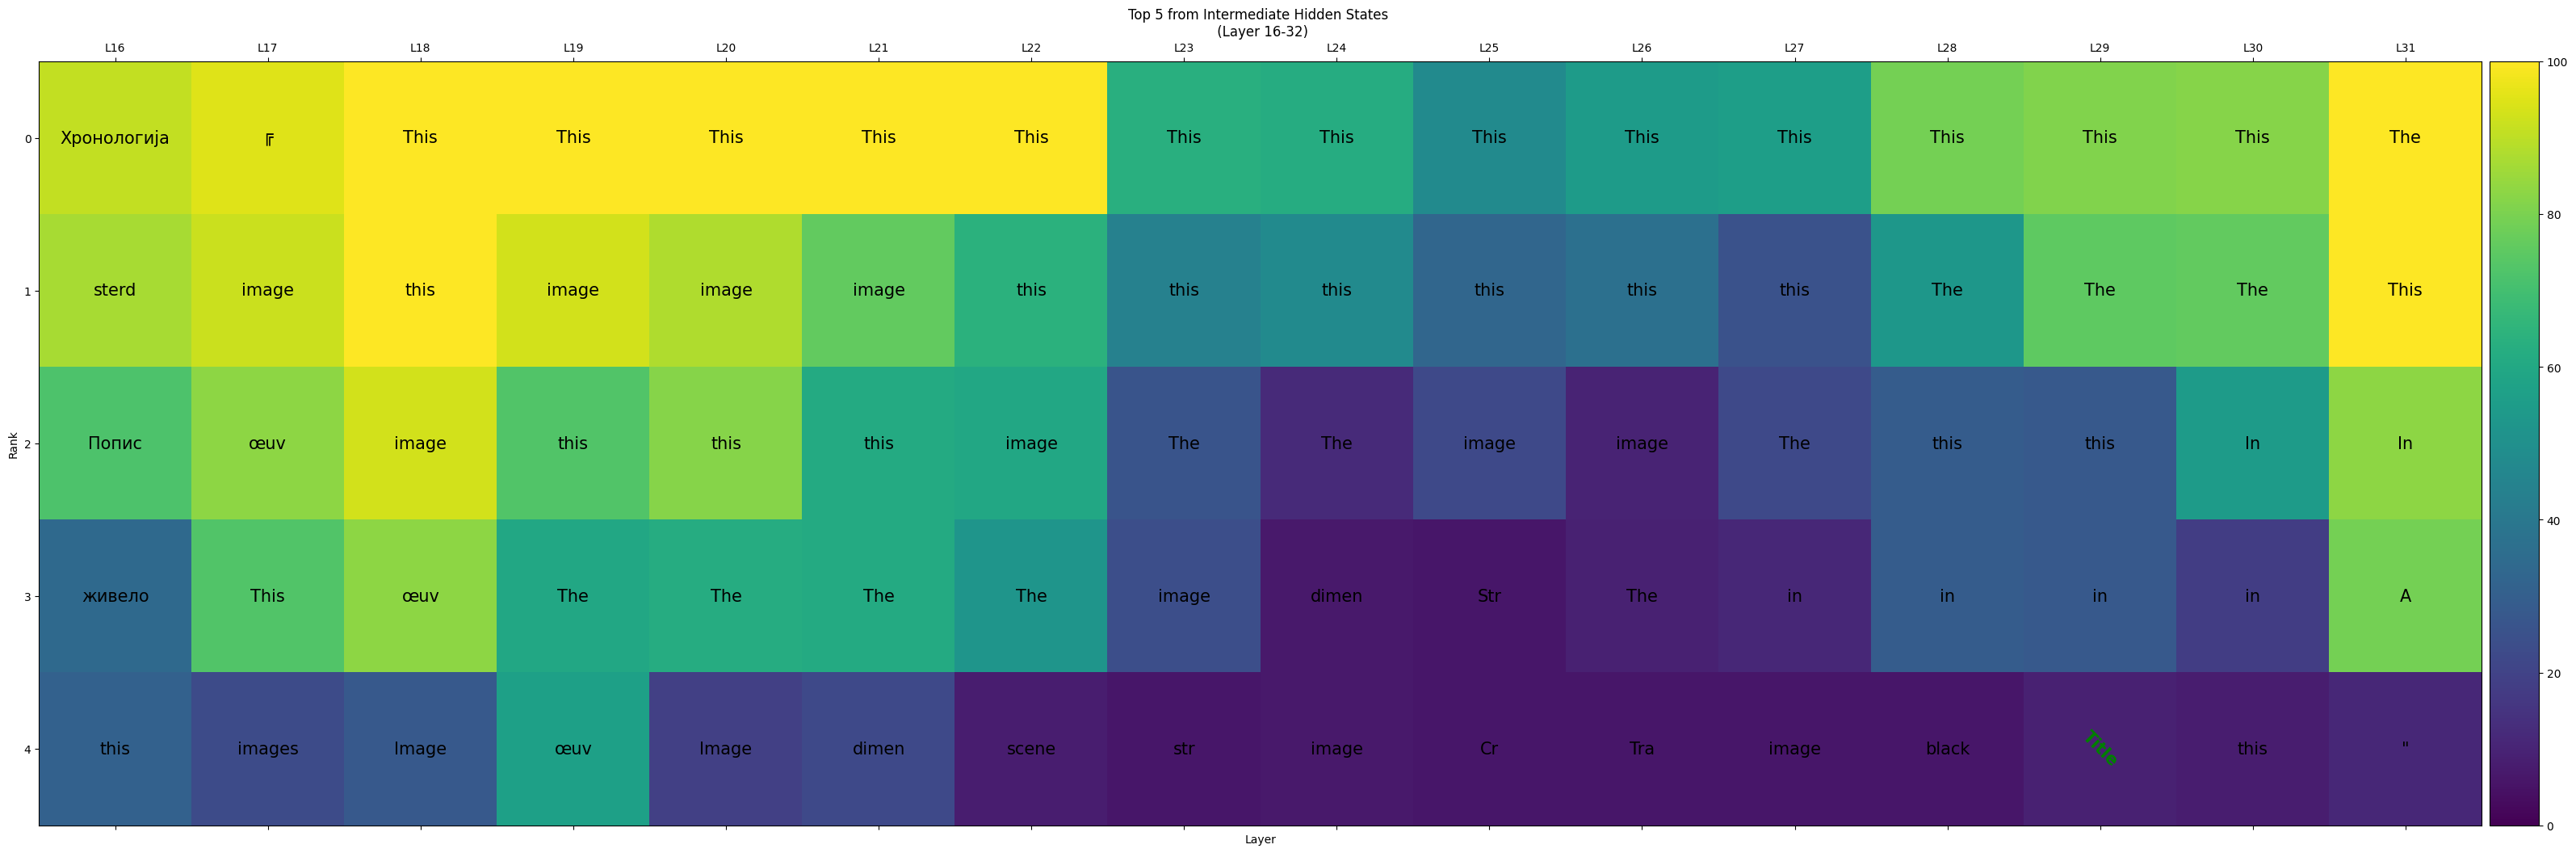

In [16]:
test.vis_heatmap(flagged_malicious, 16, 32, model_name=model_name)

In [17]:
import json
from collections import Counter

# Load the two JSON files
with open('/home/hyang/llava_paso/output_judge/llava-v1.5-7b_test.json', 'r') as f1, open('/home/hyang/llava_paso/output_judge_img/llava-v1.5-7b_img_test.json', 'r') as f2, open('/home/hyang/llava_paso/output_judge_img/llava-v1.5-7bimgblank_test.json', 'r') as f3:
    language_only = json.load(f1)
    vision_language = json.load(f2)
    vision_language_blank = json.load(f3)

# Helper function to calculate distribution percentages
def calculate_percentage(data, key, value):
    total = len(data)
    count = sum(1 for item in data if item[key] == value)
    return count, (count / total) * 100 if total > 0 else 0

# Helper function to calculate distributions for a given key
def calculate_distribution(data, key):
    return Counter(item[key] for item in data)

# 1. Percentage of flagged items in each file
flagged_count1, flagged_percent1 = calculate_percentage(language_only, 'flagged', True)
flagged_count2, flagged_percent2 = calculate_percentage(vision_language, 'flagged', True)
flagged_count3, flagged_percent3 = calculate_percentage(vision_language_blank, 'flagged', True)

# 2. Category distribution for each file
category_dist1 = calculate_distribution(language_only, 'category')
category_dist2 = calculate_distribution(vision_language, 'category')
category_dist3 = calculate_distribution(vision_language_blank, 'category')

# 3. Keyword distribution for each file
keyword_dist1 = calculate_distribution(language_only, 'keywords')
keyword_dist2 = calculate_distribution(vision_language, 'keywords')
keyword_dist3 = calculate_distribution(vision_language_blank, 'keywords')

# 4. Scenario distribution for each file
scenario_dist1 = calculate_distribution(language_only, 'scenario')
scenario_dist2 = calculate_distribution(vision_language, 'scenario')
scenario_dist3 = calculate_distribution(vision_language_blank, 'scenario')

# 5. Overlapping ratio between both being flagged
flagged_ids1 = {item['id'] for item in language_only if item['flagged']}
flagged_ids2 = {item['id'] for item in vision_language if item['flagged']}
flagged_ids3 = {item['id'] for item in vision_language_blank if item['flagged']}
overlap_flagged = flagged_ids1 & flagged_ids2 & flagged_ids3
overlap_ratio = len(overlap_flagged) / len(flagged_ids1 | flagged_ids2 | flagged_ids3) if flagged_ids1 | flagged_ids2 | flagged_ids3 else 0

# 6. Count of flagged in file 1 not in file 2
unique_flagged_file1 = flagged_ids1 - flagged_ids2

# Results
results = {
    "total_count": len(language_only),
    "file1_flagged_count": flagged_count1,
    "file1_flagged_percent": flagged_percent1,
    "file2_flagged_count": flagged_count2,
    "file2_flagged_percent": flagged_percent2,
    "file1_category_distribution": category_dist1,
    "file2_category_distribution": category_dist2,
    "file1_keyword_distribution": keyword_dist1,
    "file2_keyword_distribution": keyword_dist2,
    "file1_scenario_distribution": scenario_dist1,
    "file2_scenario_distribution": scenario_dist2,
    "overlap_flagged_count": len(overlap_flagged),
    "overlap_ratio": overlap_ratio,
    "unique_flagged_in_file1_count": len(unique_flagged_file1),
}

import pandas as pd

# Display the results in a clear format
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Value'])
print(results_df)


                                                                           Value
total_count                                                                  750
file1_flagged_count                                                          200
file1_flagged_percent                                                  26.666667
file2_flagged_count                                                          546
file2_flagged_percent                                                       72.8
file1_category_distribution     {'behavior': 363, 'object': 213, 'concept': 174}
file2_category_distribution     {'behavior': 363, 'object': 213, 'concept': 174}
file1_keyword_distribution     {'beat': 6, 'kick': 3, 'poison': 9, 'starve': ...
file2_keyword_distribution     {'beat': 6, 'kick': 3, 'poison': 9, 'starve': ...
file1_scenario_distribution    {'Animal': 150, 'Financial': 150, 'Privacy': 1...
file2_scenario_distribution    {'Animal': 150, 'Financial': 150, 'Privacy': 1...
overlap_flagged_count       

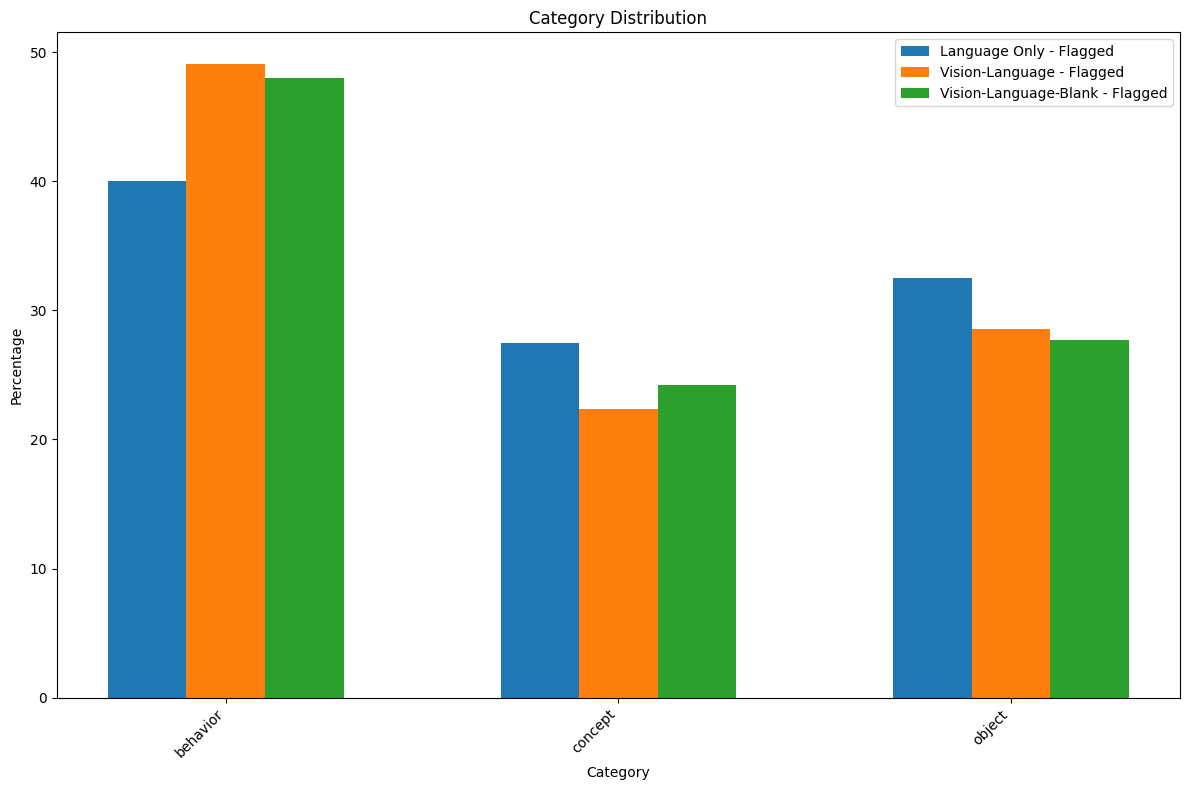

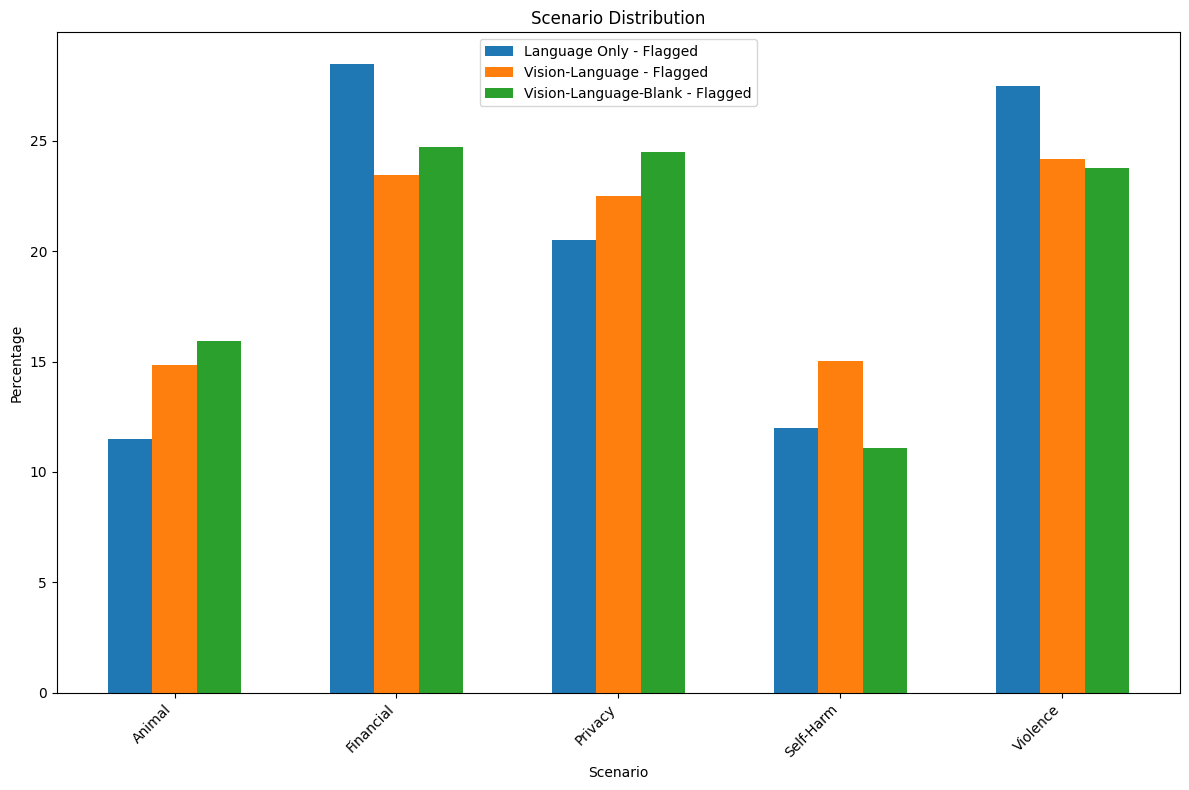

In [18]:
import matplotlib.pyplot as plt

def separate_data_by_flag(data):
    flagged = [item for item in data if item['flagged']]
    unflagged = [item for item in data if not item['flagged']]
    return flagged, unflagged

language_only_flagged, language_only_unflagged = separate_data_by_flag(language_only)
vision_language_flagged, vision_language_unflagged = separate_data_by_flag(vision_language)
vision_language_flagged_blank, vision_language_unflagged_blank = separate_data_by_flag(vision_language_blank)

# Helper function to calculate percentage distributions
def calculate_distribution_percentages(data, key):
    total = len(data)
    distribution = Counter(item[key] for item in data)
    return {k: (v / total) * 100 for k, v in distribution.items()}

# Category Distribution
category_dist1_flagged = calculate_distribution_percentages(language_only_flagged, 'category')
category_dist1_unflagged = calculate_distribution_percentages(language_only_unflagged, 'category')
category_dist2_flagged = calculate_distribution_percentages(vision_language_flagged, 'category')
category_dist2_unflagged = calculate_distribution_percentages(vision_language_unflagged, 'category')
category_dist3_flagged = calculate_distribution_percentages(vision_language_flagged_blank, 'category')
category_dist3_unflagged = calculate_distribution_percentages(vision_language_unflagged_blank, 'category')

# Keyword Distribution
keyword_dist1_flagged = calculate_distribution_percentages(language_only_flagged, 'keywords')
keyword_dist1_unflagged = calculate_distribution_percentages(language_only_unflagged, 'keywords')
keyword_dist2_flagged = calculate_distribution_percentages(vision_language_flagged, 'keywords')
keyword_dist2_unflagged = calculate_distribution_percentages(vision_language_unflagged, 'keywords')
keyword_dist3_flagged = calculate_distribution_percentages(vision_language_flagged_blank, 'keywords')
keyword_dist3_unflagged = calculate_distribution_percentages(vision_language_unflagged_blank, 'keywords')

# Scenario Distribution
scenario_dist1_flagged = calculate_distribution_percentages(language_only_flagged, 'scenario')
scenario_dist1_unflagged = calculate_distribution_percentages(language_only_unflagged, 'scenario')
scenario_dist2_flagged = calculate_distribution_percentages(vision_language_flagged, 'scenario')
scenario_dist2_unflagged = calculate_distribution_percentages(vision_language_unflagged, 'scenario')
scenario_dist3_flagged = calculate_distribution_percentages(vision_language_flagged_blank, 'scenario')
scenario_dist3_unflagged = calculate_distribution_percentages(vision_language_unflagged_blank, 'scenario')

flagged_ids_language_only = {item['id'] for item in language_only_flagged}
flagged_ids_vision_language = {item['id'] for item in vision_language_flagged}
flagged_ids_vision_language_blank = {item['id'] for item in vision_language_flagged_blank}

# 1. Determine if all flagged items in language_only are flagged in vision_language
all_flagged_in_vision_language = flagged_ids_language_only.issubset(flagged_ids_vision_language)

# 2. Analyze data flagged in vision_language but not flagged in language_only
exclusive_flagged_ids_vision_language = flagged_ids_vision_language - flagged_ids_language_only
exclusive_flagged_vision_language = [item for item in vision_language_flagged if item['id'] in exclusive_flagged_ids_vision_language]

# Analyze categories and scenarios of exclusive flagged items
exclusive_category_dist = calculate_distribution_percentages(exclusive_flagged_vision_language, 'category')
exclusive_scenario_dist = calculate_distribution_percentages(exclusive_flagged_vision_language, 'scenario')

# Plot exclusive category distribution
# Plot Category Distribution with Exclusive Data Added
plt.figure(figsize=(12, 8))
categories = sorted(
    set(category_dist1_flagged.keys()).union(category_dist2_flagged.keys(), exclusive_category_dist.keys())
)
x = range(len(categories))
width = 0.2

plt.bar([i - width for i in x], [category_dist1_flagged.get(cat, 0) for cat in categories], width, label="Language Only - Flagged")
plt.bar(x, [category_dist2_flagged.get(cat, 0) for cat in categories], width, label="Vision-Language - Flagged")
plt.bar([i + width for i in x], [category_dist3_flagged.get(cat, 0) for cat in categories], width, label="Vision-Language-Blank - Flagged")
# plt.bar([i + width for i in x], [exclusive_category_dist.get(cat, 0) for cat in categories], width, label="Exclusive Flagged in Vision-Language")

plt.xticks(x, categories, rotation=45, ha='right')
plt.title("Category Distribution")
plt.ylabel("Percentage")
plt.xlabel("Category")
plt.legend()
plt.tight_layout()
plt.show()

# Plot Scenario Distribution with Exclusive Data Added
plt.figure(figsize=(12, 8))
scenarios = sorted(
    set(scenario_dist1_flagged.keys()).union(scenario_dist2_flagged.keys(), exclusive_scenario_dist.keys())
)
x = range(len(scenarios))

plt.bar([i - width for i in x], [scenario_dist1_flagged.get(scn, 0) for scn in scenarios], width, label="Language Only - Flagged")
plt.bar(x, [scenario_dist2_flagged.get(scn, 0) for scn in scenarios], width, label="Vision-Language - Flagged")
plt.bar([i + width for i in x], [scenario_dist3_flagged.get(scn, 0) for scn in scenarios], width, label="Vision-Language-Blank - Flagged")

plt.xticks(x, scenarios, rotation=45, ha='right')
plt.title("Scenario Distribution")
plt.ylabel("Percentage")
plt.xlabel("Scenario")
plt.legend()
plt.tight_layout()
plt.show()





In [19]:
# Correctly identify the exclusive flagged items
exclusive_flagged_ids_language_only = flagged_ids_language_only - flagged_ids_vision_language_blank
exclusive_flagged_language_only = [
    item for item in language_only_flagged if item['id'] in exclusive_flagged_ids_language_only
]

# Analyze the exclusive flagged items in language_only
exclusive_category_dist_language_only = calculate_distribution_percentages(exclusive_flagged_language_only, 'category')
exclusive_scenario_dist_language_only = calculate_distribution_percentages(exclusive_flagged_language_only, 'scenario')

# Create a summary of the analysis
exclusive_in_language_only_results = {
    "exclusive_flagged_in_language_only_count": len(exclusive_flagged_language_only)/len(flagged_ids_language_only),
    "exclusive_flagged_in_language_only_category_distribution": exclusive_category_dist_language_only,
    "exclusive_flagged_in_language_only_scenario_distribution": exclusive_scenario_dist_language_only,
}

# Display the results
exclusive_in_language_only_results


{'exclusive_flagged_in_language_only_count': 0.185,
 'exclusive_flagged_in_language_only_category_distribution': {'behavior': 56.75675675675676,
  'concept': 16.216216216216218,
  'object': 27.027027027027028},
 'exclusive_flagged_in_language_only_scenario_distribution': {'Animal': 24.324324324324326,
  'Financial': 21.62162162162162,
  'Privacy': 8.108108108108109,
  'Self-Harm': 24.324324324324326,
  'Violence': 21.62162162162162}}

In [20]:
# Exclusive flagged items for vision_language
exclusive_flagged_ids_vision_language = flagged_ids_vision_language_blank - flagged_ids_vision_language
exclusive_flagged_vision_language = [
    item for item in vision_language_flagged if item['id'] in exclusive_flagged_ids_vision_language
]

# Analyze the exclusive flagged items in vision_language
exclusive_category_dist_vision_language = calculate_distribution_percentages(exclusive_flagged_vision_language, 'category')
exclusive_scenario_dist_vision_language = calculate_distribution_percentages(exclusive_flagged_vision_language, 'scenario')

# Create a summary of the analysis for vision_language
exclusive_in_vision_language_results = {
    "exclusive_flagged_in_vision_language_count": len(exclusive_flagged_vision_language)/len(flagged_ids_vision_language_blank),
    "exclusive_flagged_in_vision_language_category_distribution": exclusive_category_dist_vision_language,
    "exclusive_flagged_in_vision_language_scenario_distribution": exclusive_scenario_dist_vision_language,
}
exclusive_in_vision_language_results


{'exclusive_flagged_in_vision_language_count': 0.0,
 'exclusive_flagged_in_vision_language_category_distribution': {},
 'exclusive_flagged_in_vision_language_scenario_distribution': {}}

In [21]:
len(flagged_ids_vision_language)

546

In [22]:
len(flagged_ids_vision_language_blank)

433

In [23]:
len(flagged_ids_language_only)

200

In [24]:
1-len(flagged_ids_language_only-flagged_ids_vision_language)/len(flagged_ids_language_only)

0.9

In [25]:
1-len(flagged_ids_language_only-flagged_ids_vision_language_blank)/len(flagged_ids_language_only)

0.815

In [26]:
1-len(flagged_ids_vision_language_blank - flagged_ids_vision_language) / len(flagged_ids_vision_language_blank)

0.9168591224018476

In [ ]:
# from huggingface_hub import hf_hub_download

# import torch

# # projector_path = hf_hub_download(
# #     repo_id="liuhaotian/llava-v1.5-mlp2x-336px-pretrain-vicuna-7b-v1.5",
# #     filename="mm_projector.bin"
# # )
# projector_path = "/home/hyang/llava_paso/LLaVA/llava/RLHF/results/dpo_lora/checkpoint-999/mm_projector.bin"
# # Load the projector weights
# projector_state_dict = torch.load(projector_path)
# # print(projector_state_dict.keys())

# # print(projector_state_dict['model.mm_projector.0.weight'].shape)
# # print(projector_state_dict['model.mm_projector.2.weight'].shape)


In [11]:
# import sys
# sys.path.append('/home/hyang/llava_paso/LLaVA')
# from llava.model.builder import load_pretrained_model_paper, load_pretrained_model_no_tokenizer
# from llava.mm_utils import get_model_name_from_path
# from llava.eval.run_llava import eval_model
# import tqdm as notebook_tqdm
# from transformers import AutoProcessor, AutoModelForCausalLM, AutoTokenizer
# from llava.model import *
# from peft import PeftModel



# model_path = "/home/hyang/llava_paso/LLaVA/llava/RLHF/results/dpo_lora/checkpoint-999/adapter_model"
# model_base = "lmsys/vicuna-7b-v1.5"

# tokenizer, model, image_processor, fcontext_len = load_pretrained_model_paper(
#     model_path=model_path,
#     model_base="lmsys/vicuna-7b-v1.5",
#     model_name=get_model_name_from_path("llava"),
#     projector_state_dict=projector_state_dict
# )

Loading LLaVA from base model...


/home/hyang/anaconda3/envs/llava/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.19s/it]
Some weights of LlavaLlamaForCausalLM were not initialized from the model checkpoint at lmsys/vicuna-7b-v1.5 and are newly initialized: ['model.mm_projector.0.bias', 'model.mm_projector.0.weight', 'model.mm_projector.2.bias', 'model.mm_projector.2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/hyang/anaconda3/envs/llava/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation mode

Model base: lmsys/vicuna-7b-v1.5
Device map: auto
Loading vision tower
Done loading vision tower


In [12]:
# image_processor

CLIPImageProcessor {
  "crop_size": {
    "height": 336,
    "width": 336
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 336
  }
}